Dataset for this **Data Cleaning Challenge** was provided by Kaggle: 
https://www.kaggle.com/datasets/aparnashastry/building-permit-applications-data

The following types of data cleaning activities are performed:
1. Identify and pre-fill missing numeric and categorical values.
2. Utilize Data **Imputation** methods
3. **Parse Dates**: Check format of Date fields and create parsed date in correct format. 
4. Update inconsistent values using **Fuzzy Matching**.  


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

In [41]:
# read in all our data
sf_permits = pd.read_csv("./Building_Permits.csv",low_memory=False)

In [42]:
#Let's check if any data is missing

In [43]:
sf_permits.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [44]:
#Metadata Review

#Let's look at number of missing and populated values for each column and display top 25 columns with missing values. 

missing_values_count = sf_permits.isnull().sum()
non_missing_values_count = sf_permits.notnull().sum()

merged_na_nonna = pd.concat([missing_values_count, non_missing_values_count,sf_permits.dtypes], axis=1).reset_index()
merged_na_nonna.columns=['Field','Count of Missing Values','Count of Filled Values','Data Type']
merged_na_nonna.sort_values(by='Count of Missing Values',ascending=False)

,Field,Count of Missing Values,Count of Filled Values,Data Type
32,TIDF Compliance,198898,2,object
22,Voluntary Soft-Story Retrofit,198865,35,object
11,Unit Suffix,196939,1961,object
7,Street Number Suffix,196684,2216,object
37,Site Permit,193541,5359,object
19,Structural Notification,191978,6922,object
23,Fire Only Permit,180073,18827,object
10,Unit,169421,29479,float64
17,Completed Date,101709,97191,object
24,Permit Expiration Date,51880,147020,object


In [45]:
#Now let's check percentage of missing values
total_cells = np.product(sf_permits.shape)
total_missing = missing_values_count.sum()

#Percent of data that is missing
(total_missing/total_cells) * 100

26.26002315058403

In [46]:
#It appears that over a quarter of cells are empty. Let's explore some columns with many missing values to decide if we should
# drop na value or impute.

#Suppress scientific notation for display purposes
np.set_printoptions(suppress=True)

# sf_permits[ "TIDF Compliance"].unique() #unique values: nan, 'Y', 'P'
# sf_permits[ "Voluntary Soft-Story Retrofit"].unique() #unique values: nan, 'Y'
# sf_permits[ "Unit Suffix"].unique() #unique values: 'HOA', 'L', 'B20H', 'COMMERCIAL', "RES'L", 'UPPER', 'G', 'H', "RESID'L", 'FRONT BLDG', 'RETAIL 1', 'RESIDL 3/F', 'P', 'OFFICE 2/F', 'BLDG E',
# sf_permits[ "Street Number Suffix"].unique() #unique values: nan, 'A', 'C', 'V', 'B', 'F', 'R', 'D', '0', 'E', 'P', 'G', 'J', 'K', 'H', 'L', 'I', '½', 'N'
# sf_permits[ "Fire Only Permit"].unique() #unique values:[nan, 'Y']
# sf_permits[ "Unit"].unique() #unique values: 0.,  301.,    1.,  201., 1007.,  401.,  510.,  726.,
# sf_permits[ "Existing Construction Type"].unique() #unique values: 3.,  1.,  5., nan,  2.,  4.
# sf_permits[ "Proposed Construction Type"].unique() #unique values: nan,  1.,  5.,  3.,  4.,  2.
# sf_permits[ "Plansets"].unique() #unique values:  2.,    0.,   nan,    6.,    4.,    3.,   20., 9000.,    1.
sf_permits[ "Site Permit"].unique() #unique values: nan, 'Y'

array([nan, 'Y'], dtype=object)

In [47]:
# Imputation

#For Boolean fields - Site Permit, Fire Only Permit - let's replace nan values with N (false).
sf_permits [["Site Permit","Fire Only Permit","Voluntary Soft-Story Retrofit"]]=sf_permits [["Site Permit","Fire Only Permit","Voluntary Soft-Story Retrofit"]].fillna('N')
sf_permits[ "Fire Only Permit"].unique()


array(['N', 'Y'], dtype=object)

In [48]:
#For these string fields - replace with empty string
cols = ["Voluntary Soft-Story Retrofit","Unit Suffix","Street Number Suffix","Structural Notification","Fire Only Permit", "Unit","Existing Units"]
sf_permits [cols] = sf_permits [cols].fillna('')
sf_permits[ "Unit Suffix"].unique()

array(['', 'A', 'D', 'BLDG 1', 'C', 'B', 'E', 'FRONT', 'F', 'COMML',
       'HOA', 'L', 'B20H', 'COMMERCIAL', "RES'L", 'UPPER', 'G', 'H',
       "RESID'L", 'FRONT BLDG', 'RETAIL 1', 'RESIDL 3/F', 'P',
       'OFFICE 2/F', 'BLDG E', 'BLDG D', 'BLDG C', 'BLDG B', 'BLDG A',
       'PIER 3', 'PIER 2', 'PIER 1', 'J', 'PH-4', 'RESIDENCE', 'C132',
       'REAR UNIT', 'FRONT UNIT', 'REAR', 'LOWER', 'PH2B', 'RESIDENTIA',
       'W', 'REAR BLDG', 'PH', '#R-2', '1A-4', 'THEATRE', 'BLDG. 3',
       'RESDL/REAR', 'T', 'N', 'UTILITY', 'BLDG 3', 'O', 'LOWER UNIT',
       'FRNT RIGHT', 'MIDDLE', 'STORE', 'R', '1/F', '2/F', 'REAR G/F',
       'BLDG 449', "COM'L 1/F", 'CU-3', 'PH-1', 'FRNT BLDG', 'K',
       'LEAS OFFIC', 'COMML-3', 'S', 'M', 'PH1C', "COM'L", 'LEVEL 4',
       'BLD 7', '1503B', 'BLDG 3F', 'TENTATIVE', 'C1', 'CHILD DEV',
       'BASEMENT', '3/F', 'CU-2', 'C102', 'EAST', 'WEST', 'UPPER UNIT',
       'Garage', '0', 'COMML-2', '-A', '-B', 'FRNT ENTRA', 'C-4', 'A102',
       'BLDG 3E', '1ST 

In [49]:
#Review numeric fields to determine which missing values can be pre-filled
#sf_permits[ "Revised Cost"].head(50).unique() #unique values:
sf_permits[ "Estimated Cost"].head(50).unique() #unique values:


array([  4000.,      1.,  20000.,   2000., 100000.,  12000.,     nan,
        30000.,  75000.,  64650.,   7000.,  73000.,  18000.,  14000.])

In [50]:
#Let's use SimpleImputer package to fill missing values in Cost fields with mean values
from sklearn.impute import SimpleImputer

cost_cols = [col for col in sf_permits.columns if 'Cost' in col]



#Initialize imputer specifying "mean" strategy
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
#Apply imputation method
imputer = imputer.fit(sf_permits[cost_cols])
sf_permits[cost_cols] = imputer.transform(sf_permits[cost_cols])

#Check on the example of Estimated Cost
sf_permits[ "Estimated Cost"].head(50).unique() #unique values:


array([  4000.        ,      1.        ,  20000.        ,   2000.        ,
       100000.        ,  12000.        , 168955.44329682,  30000.        ,
        75000.        ,  64650.        ,   7000.        ,  73000.        ,
        18000.        ,  14000.        ])

In [51]:
# For Categorial values in "Proposed Use" column, let's populate missing values with most frequent ones. 

imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer = imputer.fit(sf_permits[['Proposed Use']])
sf_permits[['Proposed Use']] = imputer.transform(sf_permits[['Proposed Use']])

sf_permits[ "Proposed Use"].value_counts().head(20)


Proposed Use
1 family dwelling       88785
apartments              43032
office                  23962
2 family dwelling       22061
retail sales             5079
food/beverage hndlng     5053
tourist hotel/motel      1601
residential hotel        1002
school                    748
clinics-medic/dental      678
warehouse,no frnitur      674
artist live/work          443
manufacturing             436
church                    434
vacant lot                385
health studios & gym      332
barber/beauty salon       258
auto repairs              239
lending institution       239
public assmbly other      228
Name: count, dtype: int64

In [52]:
#Parsing Dates

#First, let's check the format of date values in the dataframe
date_cols = [col for col in sf_permits.columns if 'Date' in col]	
#print(date_cols)
sf_permits[date_cols]

,Permit Creation Date,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Permit Expiration Date
0,05/06/2015,12/21/2017,05/06/2015,11/09/2015,NaN,11/09/2015,11/03/2016
1,04/19/2016,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,12/03/2017
2,05/27/2016,09/26/2017,05/27/2016,NaN,NaN,NaN,NaN
3,11/07/2016,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,07/13/2018
4,11/28/2016,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,12/01/2018
...,...,...,...,...,...,...,...
198895,12/05/2017,12/05/2017,12/05/2017,12/05/2017,NaN,12/05/2017,NaN
198896,12/05/2017,12/06/2017,12/05/2017,12/06/2017,NaN,12/06/2017,04/06/2018
198897,12/06/2017,12/06/2017,12/06/2017,12/06/2017,NaN,12/06/2017,NaN
198898,12/06/2017,12/06/2017,12/06/2017,12/06/2017,NaN,12/06/2017,NaN


In [53]:
sf_permits['Permit Creation Date Parsed'] = pd.to_datetime(sf_permits['Permit Creation Date'])
sf_permits['Current Status Date Parsed'] = pd.to_datetime(sf_permits['Current Status Date'])
sf_permits['Completed Date Parsed'] = pd.to_datetime(sf_permits['Completed Date'])
sf_permits['Filed Date Parsed'] = pd.to_datetime(sf_permits['Filed Date'])
sf_permits['Issued Date Parsed'] = pd.to_datetime(sf_permits['Issued Date'])

In [54]:
day_of_month_landslides = sf_permits['Completed Date Parsed'].dt.day
day_of_month_landslides

0          NaN
1          NaN
2          NaN
3         24.0
4          NaN
          ... 
198895     NaN
198896     NaN
198897     NaN
198898     NaN
198899     NaN
Name: Completed Date Parsed, Length: 198900, dtype: float64

In [55]:
#Plot the day of the month to check the date parsing. This would check if the dates are within 1-31 range

<Axes: xlabel='Completed Date Parsed', ylabel='Count'>

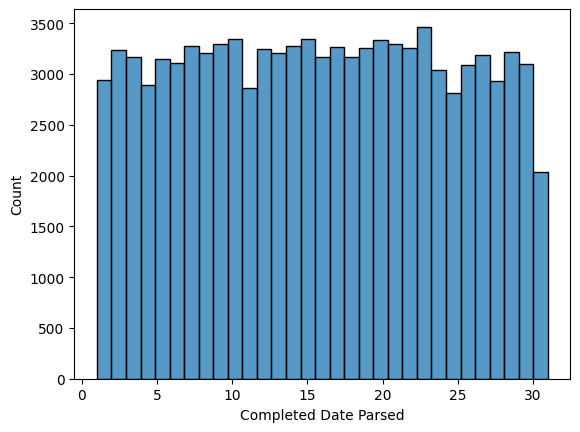

In [56]:
# remove na's
day_of_month_landslides = day_of_month_landslides.dropna()

# plot the day of the month
sns.histplot(day_of_month_landslides, kde=False, bins=31)

In [57]:
#Correcting Inconsistent Data Entries

#Let's review data values for Neighborhoods in the dataset
sf_permits["Neighborhoods - Analysis Boundaries"] = sf_permits["Neighborhoods - Analysis Boundaries"].fillna('')
neighborhoods = sf_permits["Neighborhoods - Analysis Boundaries"].unique()

neighborhoods.sort()
neighborhoods

array(['', 'Bayview Hunters Point', 'Bernal Heights',
       'Castro/Upper Market', 'Chinatown', 'Excelsior',
       'Financial District/South Beach', 'Glen Park', 'Golden Gate Park',
       'Haight Ashbury', 'Hayes Valley', 'Inner Richmond', 'Inner Sunset',
       'Japantown', 'Lakeshore', 'Lincoln Park', 'Lone Mountain/USF',
       'Marina', 'McLaren Park', 'Mission', 'Mission Bay', 'Nob Hill',
       'Noe Valley', 'North Beach', 'Oceanview/Merced/Ingleside',
       'Outer Mission', 'Outer Richmond', 'Pacific Heights', 'Portola',
       'Potrero Hill', 'Presidio', 'Presidio Heights', 'Russian Hill',
       'Seacliff', 'South of Market', 'Sunset/Parkside', 'Tenderloin',
       'Treasure Island', 'Twin Peaks', 'Visitacion Valley',
       'West of Twin Peaks', 'Western Addition'], dtype=object)

In [59]:
#While neighborhoods data in this dataset seems consistent, let's imagine that 'Presidio' and 'Presidio Heights' are the same and should be 
#combined. I am going to use fuzzywuzzy package to identify strings that are close to each other. 
import fuzzywuzzy 
from fuzzywuzzy import process

# get the top 10 closest matches to "Presidio"
matches = fuzzywuzzy.process.extract("Presidio", neighborhoods, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('Presidio', 100),
 ('Presidio Heights', 67),
 ('Excelsior', 47),
 ('Twin Peaks', 44),
 ('Sunset/Parkside', 43),
 ('Mission', 40),
 ('Portola', 40),
 ('Potrero Hill', 40),
 ('Visitacion Valley', 40),
 ('South of Market', 35)]

In [60]:
# We see that 'Presidio Heights' matches to "Presidio" at 67%. For the purposes of this exercise, I am going to 
#replace all neighbothood names that match over 60%. 

# From already found matches, only get matches with a ratio > 60
close_matches = [matches[0] for matches in matches if matches[1] >= 60]

# get the rows of all the close matches in the dataframe
rows_with_matches = sf_permits["Neighborhoods - Analysis Boundaries"].isin(close_matches)

# replace all rows with close matches with the input matches 
sf_permits.loc[rows_with_matches, "Neighborhoods - Analysis Boundaries"] = "Presidio"

sf_permits["Neighborhoods - Analysis Boundaries"].unique().sort()

In [61]:
#We can observe that all instances of "Presidio Heights" have been replaced with "Presidio"

sf_permits["Neighborhoods - Analysis Boundaries"].unique()

array(['Tenderloin', 'Russian Hill', 'Nob Hill', 'Potrero Hill',
       'Inner Sunset', 'Bayview Hunters Point', 'Lone Mountain/USF',
       'Haight Ashbury', 'Castro/Upper Market', 'Hayes Valley',
       'Noe Valley', 'Pacific Heights', 'Chinatown',
       'Financial District/South Beach', 'Marina', 'Mission',
       'Sunset/Parkside', 'Outer Richmond', 'Western Addition',
       'Bernal Heights', 'Inner Richmond', 'Oceanview/Merced/Ingleside',
       'Outer Mission', 'Portola', 'Mission Bay', 'Visitacion Valley',
       'Presidio', 'West of Twin Peaks', 'South of Market', 'Excelsior',
       'North Beach', 'Glen Park', 'Treasure Island', 'Twin Peaks',
       'Lincoln Park', '', 'Japantown', 'Lakeshore', 'Seacliff',
       'Golden Gate Park', 'McLaren Park'], dtype=object)